# Project: Predicting Survival on the *Titanic*

## Project Overview
This project predicts the number of Titanic passengers that survived on the Titanic using the following classification algorithms: Logistic Regression, Support Vectors Machine, and K Nearest Neighbors. Out of the three classification models used, the Support Vector Machines model had the highest test accuracy (82.51%) compared to the other two classification models. 

## Info on Dataset

| **Variable** | **Definition**                             | **Key**                                         |
|--------------|--------------------------------------------|-------------------------------------------------|
| survival     | Survival                                   | 0 = No, 1 = Yes                                 |
| pclass       | Ticket class                               | 1 = 1st, 2 = 2nd, 3 = 3rd                       |
| sex          | Sex                                        |                                                 |
| Age          | Age in years                               |                                                 |
| sibsp        | # of siblings / spouses abord the Titanic  |                                                 |
| parch        | # of parents / children aboard the Titanic |                                                 |
| ticket       | Ticket number                              |                                                 |
| fare         | Passenger fare                             |                                                 |
| cabin        | Cabin number                               |                                                 |
| embarked     | Port of Embarkation                        | C = Cherbourgh, Q = Queenstown, S = Southampton |

In [1]:
# Imported Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

# Importing this to ignore warnings for K Nearest Neighbors
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load Titanic.csv file
# Used the usecols argument to extract relevant columns
# Columns dropped: 'Ticket', 'Name', 'Cabin', and 'PassengerID'
titanic = pd.read_csv('Titanic.csv', usecols = ['Survived', 'Sex','Age','SibSp','Parch',
                                                'Pclass','Fare','Embarked'])

titanic.head(20)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S
5,0,3,male,NaN,0,0,8.4583,Q
6,0,1,male,54.0,0,0,51.8625,S
7,0,3,male,2.0,3,1,21.0750,S
8,1,3,female,27.0,0,2,11.1333,S
9,1,2,female,14.0,1,0,30.0708,C


In [3]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


## Functions utilized for this report

### Function for finding the best number of k-folds for cross validation
This function finds the best number of k-folds to use for cross-validation to improve model accuracy. Go to the **Appendix** section to see how the k-fold value was determined for each of the algorithms used in this report

In [4]:
# Function for plotting the best k-fold value for cross validation
def find_best_k(pipeline, plot_title):
    ''' This function finds the best number of k-folds to 
    use for cross-validation to imporive model accuracy'''
    k = list(range(2, 11))
    mean_accuracy = []

    for i in k:
        scores = cross_val_score(pipeline, X_train, y_train, cv=i)
        mean_accuracy.append(scores.mean())
    
    k_df = pd.DataFrame(k)
    k_df.rename({0:'k'}, axis=1, inplace=True)

    mean_accuracy_df = pd.DataFrame(mean_accuracy)*100
    mean_accuracy_df.rename({0:'mean accuracy'}, axis=1, inplace=True)
    
    # Creating plot for plotting mean accuracy values for each k value
    cv_plot = pd.concat([k_df, mean_accuracy_df], axis=1)
    plt.plot(cv_plot['k'], cv_plot['mean accuracy'])
    plt.xlabel('k')
    plt.ylabel('Mean accuracy %')
    plt.title(plot_title)
    plt.show()

### Function for plotting the confusion matrix for each model
This function plots the confusion matrix for each of the three algorithms used in this report. 

In [5]:
# Creating a function to plot confusion matrix
def plot_confusion_matrix(y,y_predict):
    "This function plots the confusion matrix"

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set(xlabel='Predicted labels',
           ylabel='True labels',
           title='Confusion Matrix');
    ax.xaxis.set_ticklabels(['Not Survived', 'Survived']); ax.yaxis.set_ticklabels(['Did not Survive', 'Survived'])

## Preprocessing, Cleaning, and Train/Test/Split Data

In [6]:
# Features matrix
X = titanic.drop(['Survived'], axis = 1)

# Target variable
y = titanic['Survived'].ravel() # Used numpy ravel() function to change shape of y

# Converting categorical variables to numeric variables
titanic_one_hot = pd.get_dummies(data = X, columns = ['Sex', 'Embarked'])

# Reassigning X to include one hot encoded columns
X = pd.DataFrame(titanic_one_hot)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [7]:
# Number or rows in training and test sets
print("Number of rows in training set: {}".format(len(X_train)))
print("Number of rows in test set: {}".format(len(X_test)))

Number of rows in training set: 668
Number of rows in test set: 223


## Building the Baseline Model: Logistic Regression

In [8]:
# Created pipeline for logistic regression
log_reg_pipe = Pipeline([('imp_mean', SimpleImputer(missing_values=np.nan, strategy='mean')), 
                         ('scaler', StandardScaler()), 
                         ('log_reg', LogisticRegression())])

# Using GridSearchCV to find the best parameters for the model
lr_params = {"log_reg__C": [0.01, 0.1, 1, 2, 5, 10], 
             'log_reg__penalty':['l2'], 
             'log_reg__solver': ['lbfgs']}
             

log_reg_cv = GridSearchCV(log_reg_pipe, lr_params, cv=4)


# Fitting the pipeline data with the best parameters
log_reg_cv.fit(X_train, y_train)

print("tuned hyperparameters: (best parameters) ", log_reg_cv.best_params_)
print("accuracy: ", log_reg_cv.best_score_)

tuned hyperparameters: (best parameters)  {'log_reg__C': 2, 'log_reg__penalty': 'l2', 'log_reg__solver': 'lbfgs'}
accuracy:  0.8008982035928144


In [9]:
# Calculating accuracy of test data
log_reg_accuracy = log_reg_cv.score(X_test, y_test)
print('Accuracy using test data: ' ,np.round(log_reg_accuracy, 4)*100)

Accuracy using test data:  80.72


[[115  19]
 [ 24  65]]


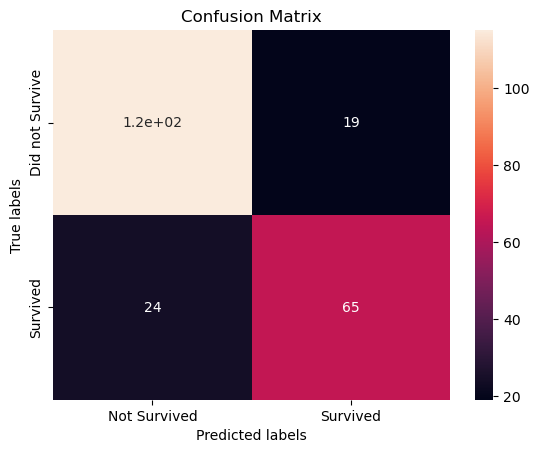

In [10]:
# Calculating predicted values an dplotting confusion matrix
y_hat_lr = log_reg_cv.predict(X_test)
print(confusion_matrix(y_test, y_hat_lr))
plot_confusion_matrix(y_test, y_hat_lr)

### Results of Logistic Regression Model

- Best hyperparametes: 'log_reg__C': 2, 'log_reg__penalty': 'l2', 'log_reg__solver': 'lbfgs', with accuracy of 80.01%

- Accuracy of test data set: 80.72%

- Total number of correct predictions: 180 (115 Did not survive and 65 survived)

- Model predicted 24 passengers not survived when the true label is 'Survived'

- Model predicted 19 passengers survived when the true label is 'Did not survive'

## Using the Support Vector Machines Model

In [11]:
# Created pipeline for support vector machines
svm_pipe = Pipeline([('imp_mean', SimpleImputer(missing_values=np.nan, strategy='mean')), 
                     ('scaler', StandardScaler()), 
                     ('SVC', SVC())])

# Using GridSearchCV to find best parameters for the model
svm_params = {"SVC__C": [0.01, 0.1, 1, 2, 5, 10],
              "SVC__kernel": ['linear', 'poly', 'rbf', 'sigmoid']}

svm_cv = GridSearchCV(svm_pipe, svm_params, cv=7)

# Fitting the pipeline data with the best parameters
svm_cv.fit(X_train, y_train)

print("tuned hyperparameters: (best parameters) ", svm_cv.best_params_)
print("accuracy: ", svm_cv.best_score_)

# Calculating accuracy of test data
svm_accuracy = svm_cv.score(X_test, y_test)
print('Accuracy using test data: ', np.round(svm_accuracy, 4)*100)

tuned hyperparameters: (best parameters)  {'SVC__C': 2, 'SVC__kernel': 'rbf'}
accuracy:  0.8292763157894737
Accuracy using test data:  82.50999999999999


[[123  11]
 [ 28  61]]


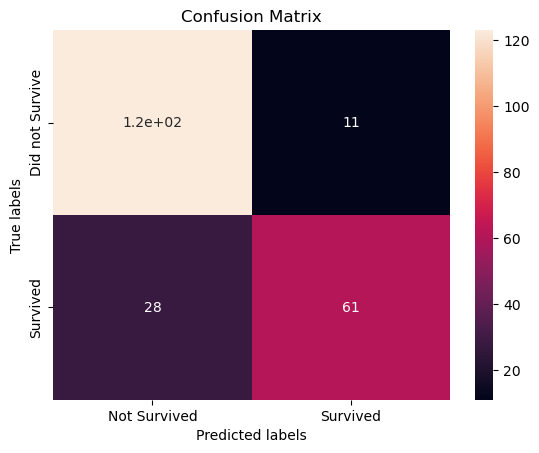

In [12]:
# Calculating predicted values and plotting confusion matrix
y_hat_svm = svm_cv.predict(X_test)
print(confusion_matrix(y_test, y_hat_svm ))
plot_confusion_matrix(y_test, y_hat_svm )

### Results of Support Vector Machines Model

- Best hyperparametes: 'SVC__C': 2, 'SVC__kernel': 'rbf', with accuracy of 82.93%

- Accuracy of test data set: 82.51%

- Total number of correct predictions: 184 (123 Did not survive and 61 survived)

- Model predicted 28 passengers not survived when the true label is 'Survived'

- Model predicted 11 passengers survived when the true label is 'Did not survive'

## Using K Nearest Neighbors Model

In [13]:
from sklearn.neighbors import KNeighborsClassifier

# Created pipeline for support vector machines
knn_pipe = Pipeline([('imp_mean', SimpleImputer(missing_values=np.nan, strategy='mean')), 
                     ('scaler', StandardScaler()), 
                     ('KNN', KNeighborsClassifier())])

# Using GridSearchCV to find best parameters for the model
knn_params = {'KNN__n_neighbors': list(range(1, 11)),
              'KNN__algorithm': ['ball_tree', 'kd_tree', 'brute'],
              'KNN__p': [1,2]} # p=1 used manhattan distance and p=2 used eucledian distance

knn_cv = GridSearchCV(knn_pipe, knn_params, cv=4)

# Fitting the pipeline data with the best parameters
knn_cv.fit(X_train, y_train)

print("tuned hyperparameters: (best parameters) ", knn_cv.best_params_)
print("accuracy: ", knn_cv.best_score_)

# Calculating accuracy of test data
knn_accuracy = knn_cv.score(X_test, y_test)
print('Accuracy using test data: ', np.round(knn_accuracy, 2))

tuned hyperparameters: (best parameters)  {'KNN__algorithm': 'ball_tree', 'KNN__n_neighbors': 10, 'KNN__p': 1}
accuracy:  0.8293413173652695
Accuracy using test data:  0.81


[[122  12]
 [ 30  59]]


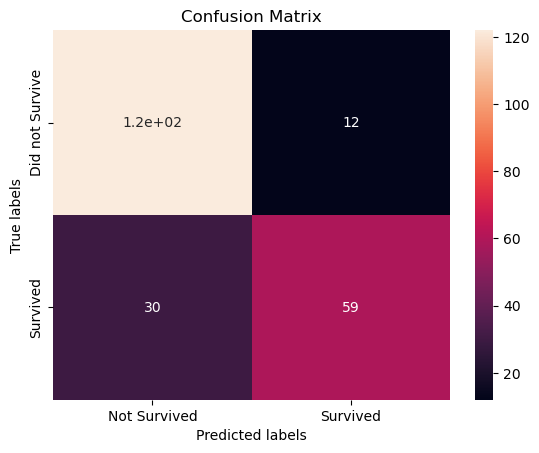

In [14]:
# Calculating predicted values and plotting confusion matrix
y_hat_knn = knn_cv.predict(X_test)
print(confusion_matrix(y_test, y_hat_knn))
plot_confusion_matrix(y_test, y_hat_knn)

### Results of K Nearest Neighbor Model

- Best hyperparametes: 'KNN__algorithm': 'ball_tree', 'KNN__n_neighbors': 10, 'KNN__p': 1, with accuracy of 82.93%

- Accuracy of test data set: 81.17%

- Total number of correct predictions: 181 (122 Did not survive and 59 survived)

- Model predicted 30 passengers not survived when the true label is 'Survived'

- Model predicted 12 passengers survived when the true label is 'Did not survive'

## Results comparing the three models

Since we are trying to predict the number of Titanic passengers that survived, the **Survived** column is the target variable. All other columns were used for the features matrix (except for columns PassengerID, Name, Ticket, and Cabin.

When preparing the data for modeling, the columns 'Sex' and 'Embarked' were one hot encoded so that the columns are numerical. The NaN values in the 'Age' column were imputed AFTER train/test/split data using the average Age. A pipeline was used for every model and the function find_best_k was used to find the best k-fold value for cross validation. After finding the best k-fold value, then GridSearchCV was used to tune hyperparameter and find the best hyperparameters to achieve the highest accuracy.

The baseline model used is Logistic Regression since there are only two outcomes 'Survived' and 'Not Survived'. The other two models used were Support Vector Machines and K Nearest Neighbors to compare the baseline model. All models were evaluated using the accuracy of the test data and the confusion matrix to compare the true vs. predicted labels. 

Below is the barchart to compare the accuracy of the test data for each of the three models

<Figure size 2000x1200 with 0 Axes>

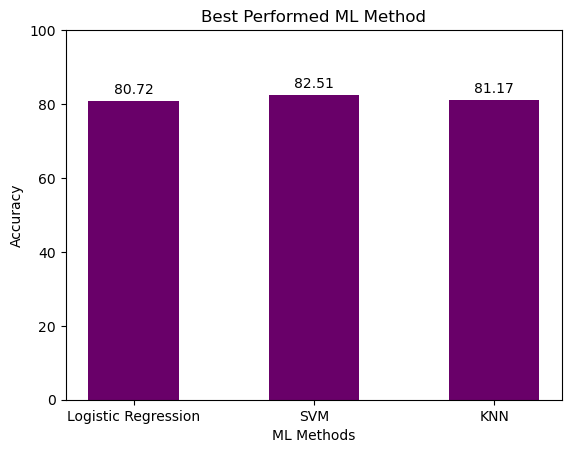

In [15]:
plt.figure(figsize = (20, 12))

methods = ['Logistic Regression', 'SVM', 'KNN']
accuracy = [np.round(log_reg_accuracy, 4)*100, np.round(svm_accuracy, 4)*100, np.round(knn_accuracy, 4)*100]

fig, ax = plt.subplots()
ax.bar(methods, accuracy, color = '#690069', width=0.5)

for bar in ax.patches:
   
  # Using Matplotlib's annotate function and
  # passing the coordinates where the annotation shall be done
  # x-coordinate: bar.get_x() + bar.get_width() / 2
  # y-coordinate: bar.get_height()
  # free space to be left to make graph pleasing: (0, 8)
  # ha and va stand for the horizontal and vertical alignment
    ax.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   xytext=(0, 8),
                   textcoords='offset points')
    
ax.set(xlabel="ML Methods",
       ylabel="Accuracy",
       title="Best Performed ML Method",
       ylim = (0, 100))
plt.show()

From the above plot, the **Support Vector Machines** model has the highest accuracy for test data (82.51%) compared to the other two models. 

The baseline model (**Logistic Regression**) had the lowest acuuracy for test data of 80.72%

## Appendix

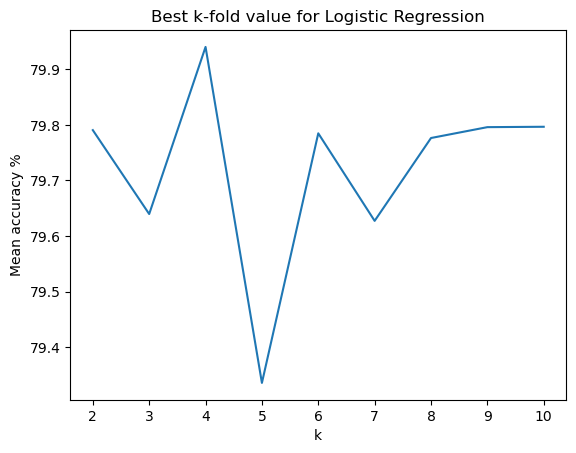

In [16]:
# Finding best k value for Logistic Regression
find_best_k(log_reg_pipe, 'Best k-fold value for Logistic Regression')

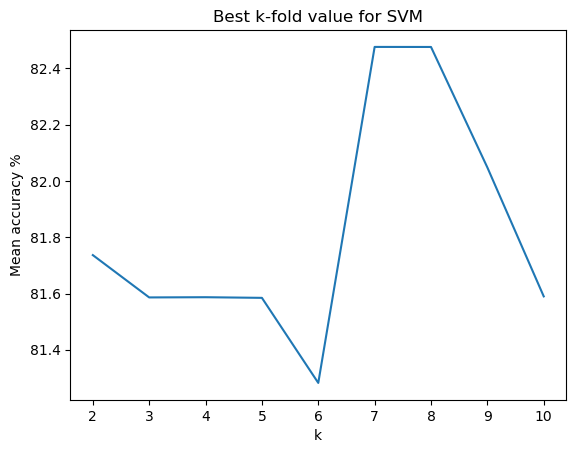

In [17]:
# Finding best k value for Support Vector Machines
find_best_k(svm_pipe, 'Best k-fold value for SVM')

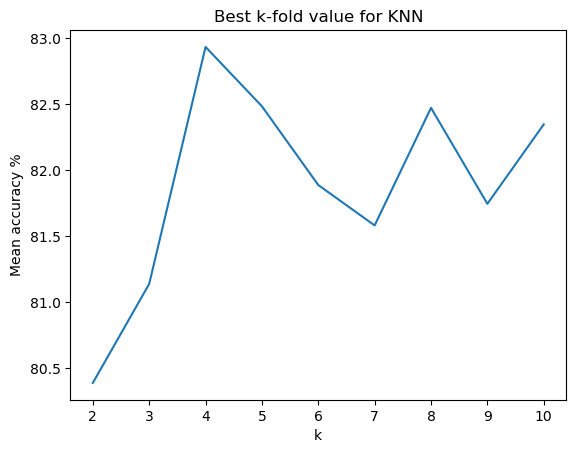

In [18]:
# Generating a knn pipeline using the best parameters
knn_pipe_best = Pipeline([('imp_mean',SimpleImputer(missing_values=np.nan, strategy='mean')),
                          ('scaler', StandardScaler()), 
                          ('KNN', KNeighborsClassifier(n_neighbors=10, algorithm = 'ball_tree', p=1))])

# Generating plot for finding best k-fold value for cross validation using pipeline above
find_best_k(knn_pipe_best, 'Best k-fold value for KNN')